In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error, classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Incendios Forestales

El objetivo es crear 2 nuevas variables:

* Hay o no incendio (si area > 0, hay incendio, eoc no)

* Magnitud del Incenido (usar el área en escala logarítmica si área > 0).

Se deben proponer 2 modelos, uno de clasificación y uno de regresión.
Al final habrá que comparar el modelo contra los datos reales para ver el poder predictivo.
No importa que se tenga el mejor modelo, lo que importa es entender que se está haciendo,
entender los pasos que se están siguiendo, asi como saber que modelos se conocen para dichos procesos.

Entragables: 
Explicar la metodologia que se uso para cada modelo

Requerimientos mínimos:  
Apoyo gráfico
una medida de desempeño, 
explicar por que se uso dicho modelo.

In [228]:
url = 'https://raw.githubusercontent.com/AngelGuadarrama/Forest-Fires/main/forestfires.csv'
data = pd.read_csv(url)
data.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [229]:
#Creamos nuestras nuevas columnas
data['incendio']=[value > 0 for value in data.area] 
data['magnitud']=np.log(data[data.area> 0]['area'])
data.fillna({'magnitud': 0}, inplace=True)

Variables Numericas

In [136]:
data[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain']].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000


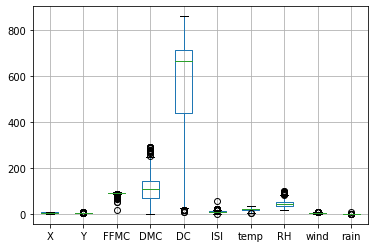

In [22]:
data[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain']].boxplot()
plt.show()       

In [230]:
data['DC_log']=np.log(data.DC) #Esta columna tiene una varianza muy alta
data.drop(['DC'], inplace=True, axis=1)

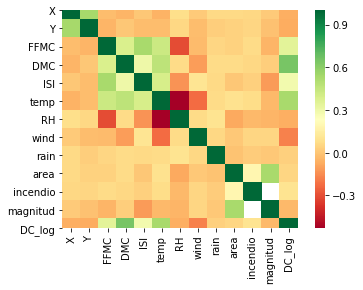

In [24]:
#Quitaremos RH ya que tiene correlacion con la temperatura
sns.heatmap(data.corr(), square= True, cmap='RdYlGn') 
#data.drop(['RH'], inplace=True, axis=1)

Variables categoricas: aplicaremos dummys en el caso de regresión y target mean en el caso de clasificación.


In [30]:
data.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [31]:
data.day.value_counts() #Parece ser que los fines de semana hay mas incendios

sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

In [231]:
data['day'].replace({'mon':'0','tue':'0','wed':'0','thu':'0','fri':'1','sat':'1','sun':'1'}, inplace=True)
data.day=data[['day']].apply(lambda x: x.astype('float64'), axis=0)

In [165]:
data.head()

,X,Y,month,day,FFMC,DMC,ISI,temp,RH,wind,rain,area,incendio,magnitud,DC_log
0,7,5,mar,1.0,86.2,26.2,5.1,8.2,51,6.7,0.0,0.0,False,0.0,4.546481
1,7,4,oct,0.0,90.6,35.4,6.7,18.0,33,0.9,0.0,0.0,False,0.0,6.505934
2,7,4,oct,1.0,90.6,43.7,6.7,14.6,33,1.3,0.0,0.0,False,0.0,6.532189
3,8,6,mar,1.0,91.7,33.3,9.0,8.3,97,4.0,0.2,0.0,False,0.0,4.350278
4,8,6,mar,1.0,89.3,51.3,9.6,11.4,99,1.8,0.0,0.0,False,0.0,4.626932


Modelo de Clasificación

En este caso elegí trabajar con un modelo de regresion logistica porque es un modelo simple que puede ser buena eleccion para empezar a experimentar. Las metrica que se utilizo fue AUC por su interpretabilidad conforme al azar y la clasica matriz de confusión. 

In [232]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values


def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=2424, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values


def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


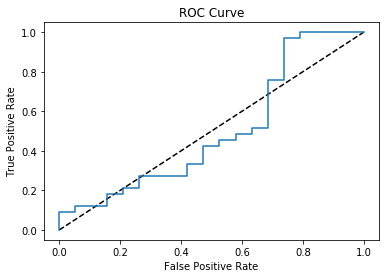

AUC: 0.4992025518341308
              precision    recall  f1-score   support

       False       0.30      0.32      0.31        19
        True       0.59      0.58      0.58        33

    accuracy                           0.48        52
   macro avg       0.45      0.45      0.45        52
weighted avg       0.49      0.48      0.48        52

[[ 6 14]
 [13 19]]


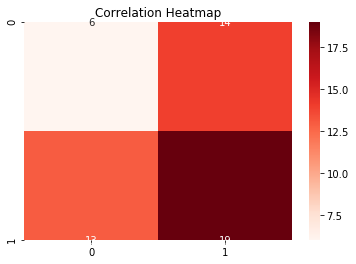

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


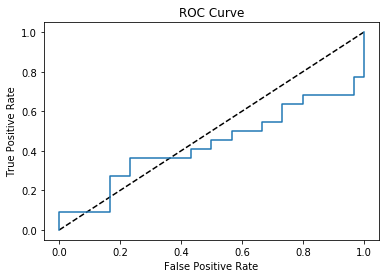

AUC: 0.4318181818181818
              precision    recall  f1-score   support

       False       0.43      0.20      0.27        30
        True       0.37      0.64      0.47        22

    accuracy                           0.38        52
   macro avg       0.40      0.42      0.37        52
weighted avg       0.40      0.38      0.35        52

[[ 6  8]
 [24 14]]


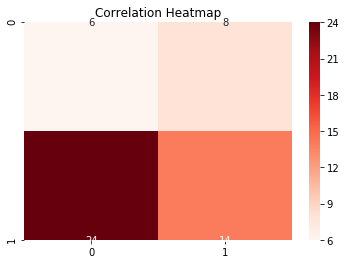

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


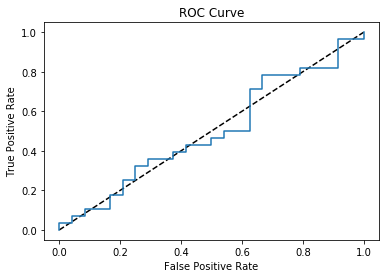

AUC: 0.49851190476190477
              precision    recall  f1-score   support

       False       0.50      0.38      0.43        24
        True       0.56      0.68      0.61        28

    accuracy                           0.54        52
   macro avg       0.53      0.53      0.52        52
weighted avg       0.53      0.54      0.53        52

[[ 9  9]
 [15 19]]


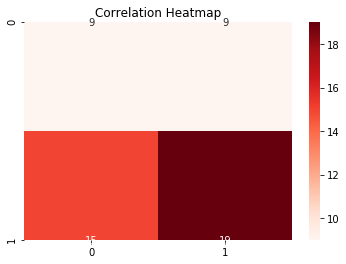

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


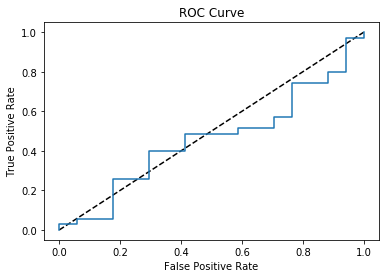

AUC: 0.45714285714285713
              precision    recall  f1-score   support

       False       0.28      0.41      0.33        17
        True       0.63      0.49      0.55        35

    accuracy                           0.46        52
   macro avg       0.45      0.45      0.44        52
weighted avg       0.52      0.46      0.48        52

[[ 7 18]
 [10 17]]


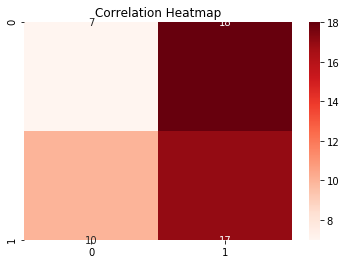

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


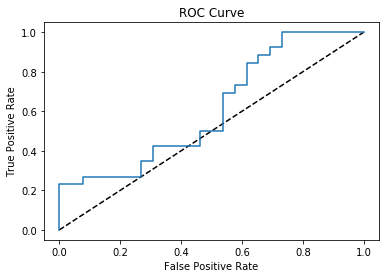

AUC: 0.6124260355029586
              precision    recall  f1-score   support

       False       0.71      0.38      0.50        26
        True       0.58      0.85      0.69        26

    accuracy                           0.62        52
   macro avg       0.65      0.62      0.59        52
weighted avg       0.65      0.62      0.59        52

[[10  4]
 [16 22]]


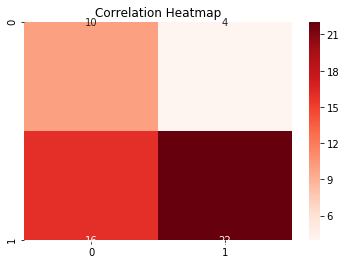

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


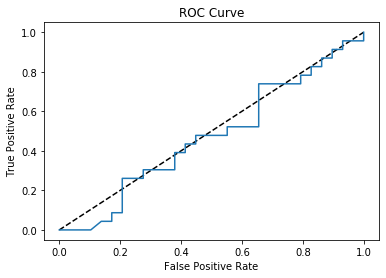

AUC: 0.4715142428785607
              precision    recall  f1-score   support

       False       0.60      0.31      0.41        29
        True       0.46      0.74      0.57        23

    accuracy                           0.50        52
   macro avg       0.53      0.52      0.49        52
weighted avg       0.54      0.50      0.48        52

[[ 9  6]
 [20 17]]


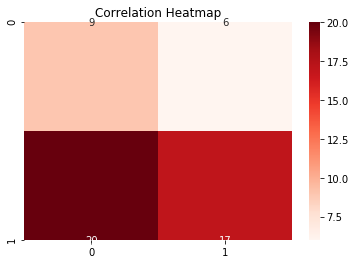

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


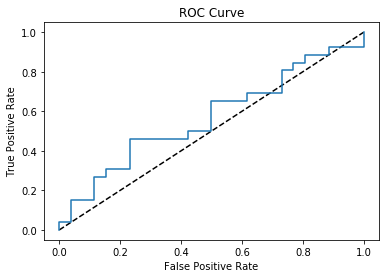

AUC: 0.5680473372781065
              precision    recall  f1-score   support

       False       0.57      0.46      0.51        26
        True       0.55      0.65      0.60        26

    accuracy                           0.56        52
   macro avg       0.56      0.56      0.55        52
weighted avg       0.56      0.56      0.55        52

[[12  9]
 [14 17]]


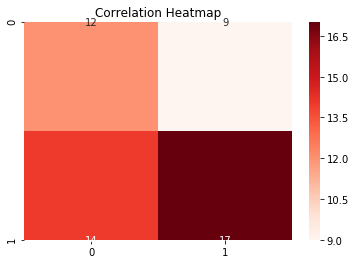

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


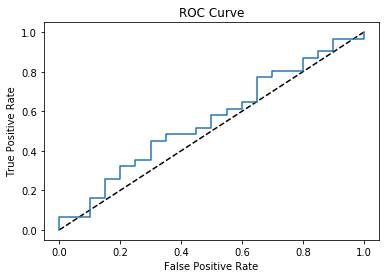

AUC: 0.5548387096774193
              precision    recall  f1-score   support

       False       0.42      0.40      0.41        20
        True       0.62      0.65      0.63        31

    accuracy                           0.55        51
   macro avg       0.52      0.52      0.52        51
weighted avg       0.55      0.55      0.55        51

[[ 8 11]
 [12 20]]


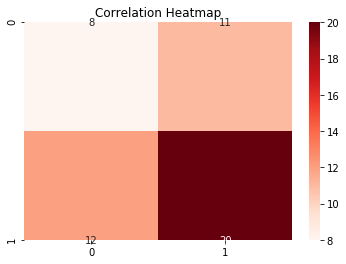

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


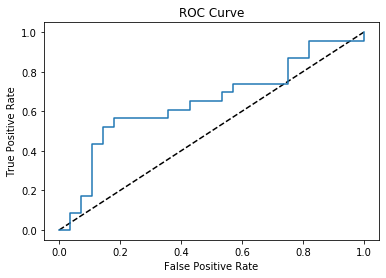

AUC: 0.6475155279503106
              precision    recall  f1-score   support

       False       0.62      0.36      0.45        28
        True       0.49      0.74      0.59        23

    accuracy                           0.53        51
   macro avg       0.56      0.55      0.52        51
weighted avg       0.56      0.53      0.51        51

[[10  6]
 [18 17]]


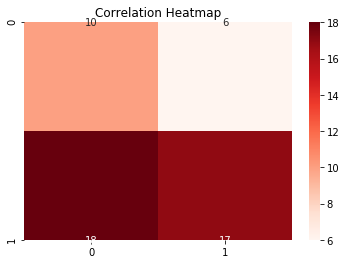

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


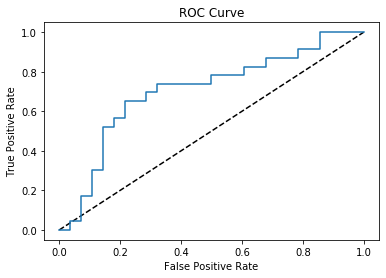

AUC: 0.7049689440993788
              precision    recall  f1-score   support

       False       0.71      0.36      0.48        28
        True       0.51      0.83      0.63        23

    accuracy                           0.57        51
   macro avg       0.61      0.59      0.55        51
weighted avg       0.62      0.57      0.55        51

[[10  4]
 [18 19]]


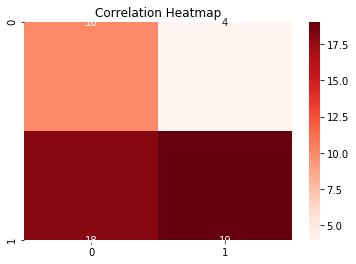

In [240]:
# Create n-fold cross-validation
kf = KFold(n_splits=10, random_state=123, shuffle=True)
roc_auc_score_list=[]

# For each folds split
for train_index, test_index in kf.split(data):
    
    cv_train, cv_test = data.iloc[train_index], data.iloc[test_index]

    cv_train['month_enc'], cv_test['month_enc'] = mean_target_encoding(train=cv_train,
                                                                           test=cv_test,
                                                                           target='incendio',
                                                                           categorical='month',
                                                                           alpha=5)

    #print(cv_train_dm.shape, cv_test_dm.shape)
    #print(cv_train.shape, cv_test.shape)

    #Estandarizamos las variables numericas
    ss1=StandardScaler()
    ss2=StandardScaler()
    ss3=StandardScaler()
    ss4=StandardScaler()
    ss5=StandardScaler()
    ss6=StandardScaler()
    ss7=StandardScaler()
    ss8=StandardScaler()
    ss9=StandardScaler()
    ss10=StandardScaler()

    ss1.fit(cv_train[['X']])
    ss2.fit(cv_train[['Y']])    
    ss3.fit(cv_train[['FFMC']])
    ss4.fit(cv_train[['DMC']])
    ss5.fit(cv_train[['DC_log']])
    ss6.fit(cv_train[['ISI']])
    ss7.fit(cv_train[['temp']])
    ss8.fit(cv_train[['RH']])
    ss9.fit(cv_train[['wind']])
    ss10.fit(cv_train[['rain']])

    cv_train_enc=pd.concat([pd.DataFrame(ss1.transform(cv_train[['X']]), columns=['X']), 
                           pd.DataFrame(ss2.transform(cv_train[['Y']]), columns=['Y']),
                           pd.DataFrame(ss3.transform(cv_train[['FFMC']]), columns=['FFMC']),
                           pd.DataFrame(ss4.transform(cv_train[['DMC']]), columns=['DMC']),
                           pd.DataFrame(ss5.transform(cv_train[['DC_log']]), columns=['DC_log']),
                           pd.DataFrame(ss6.transform(cv_train[['ISI']]), columns=['ISI']),
                           pd.DataFrame(ss7.transform(cv_train[['temp']]), columns=['temp']),
                           pd.DataFrame(ss8.transform(cv_train[['RH']]), columns=['RH']),
                           pd.DataFrame(ss9.transform(cv_train[['wind']]), columns=['wind']), 
                           pd.DataFrame(ss10.transform(cv_train[['rain']]), columns=['rain']) ], axis=1)
    
    cv_test_enc=pd.concat([pd.DataFrame(ss1.transform(cv_test[['X']]), columns=['X']), 
                           pd.DataFrame(ss2.transform(cv_test[['Y']]), columns=['Y']),
                           pd.DataFrame(ss3.transform(cv_test[['FFMC']]), columns=['FFMC']),
                           pd.DataFrame(ss4.transform(cv_test[['DMC']]), columns=['DMC']),
                           pd.DataFrame(ss5.transform(cv_test[['DC_log']]), columns=['DC_log']),
                           pd.DataFrame(ss6.transform(cv_test[['ISI']]), columns=['ISI']),
                           pd.DataFrame(ss7.transform(cv_test[['temp']]), columns=['temp']),
                           pd.DataFrame(ss8.transform(cv_test[['RH']]), columns=['RH']),
                           pd.DataFrame(ss9.transform(cv_test[['wind']]), columns=['wind']), 
                           pd.DataFrame(ss10.transform(cv_test[['rain']]), columns=['rain']) ], axis=1)
    

    #Training
    X_train, y_train= pd.concat([cv_train_enc.reset_index(), 
                                 cv_train[['month_enc']].reset_index(),
                                 cv_train[['day']].reset_index()], axis=1), cv_train[['incendio']]
    X_test, y_test= pd.concat([cv_test_enc.reset_index(), 
                               cv_test[['month_enc']].reset_index(),
                               cv_test[['day']].reset_index()], axis=1), cv_test[['incendio']]
    
    X_train.drop(['index'], inplace=True, axis=1)
    X_test.drop(['index'], inplace=True, axis=1)
    
    #print(X_train.head())

    logreg= LogisticRegression()
    logreg.fit(X_train.values, y_train.values.ravel())
     
    y_pred= logreg.predict(X_test) 
    y_pred_proba= logreg.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_proba)
    
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    score=roc_auc_score(y_test, y_pred_proba)
    roc_auc_score_list.append(score) 
    print("AUC: {}".format(score))
    
    print(classification_report(y_test, y_pred))
    corr=confusion_matrix(y_pred, y_test)
    print(corr)
     
    heatmap=sns.heatmap(corr, annot=True, fmt="d", cmap="Reds")
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12})
    
    plt.show()
    

In [168]:
print("Average_AUC: {}".format(np.mean(roc_auc_score_list)))

Average_AUC: 0.544598629294381


Modelo de Regresion

En este caso elegí trabajar con un modelo de regresion lineal porque es un modelo simple que puede ser buena eleccion para empezar a experimentar. Las metricas que se utilizaran son MAE por su facil interpretabilidad y RMSE para tomar en cuenta la variación del error.

In [169]:
data_regression=pd.get_dummies(data, columns=['month'], drop_first=True, prefix='DM')

In [170]:
data_regression.head()

,X,Y,day,FFMC,DMC,ISI,temp,RH,wind,rain,...,DM_dec,DM_feb,DM_jan,DM_jul,DM_jun,DM_mar,DM_may,DM_nov,DM_oct,DM_sep
0,7,5,1.0,86.2,26.2,5.1,8.2,51,6.7,0.0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,0.0,90.6,35.4,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,1.0,90.6,43.7,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,1.0,91.7,33.3,9.0,8.3,97,4.0,0.2,...,0,0,0,0,0,1,0,0,0,0
4,8,6,1.0,89.3,51.3,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,1,0,0,0,0


In [172]:
data_regression.columns

Index(['X', 'Y', 'day', 'FFMC', 'DMC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area', 'incendio', 'magnitud', 'DC_log', 'DM_aug', 'DM_dec', 'DM_feb',
       'DM_jan', 'DM_jul', 'DM_jun', 'DM_mar', 'DM_may', 'DM_nov', 'DM_oct',
       'DM_sep'],
      dtype='object')

In [185]:
# Create n-fold cross-validation
kf = KFold(n_splits=10, random_state=24, shuffle=True)
MAE_list=[]
RMSE_list=[]

# For each folds split
for train_index, test_index in kf.split(data_regression):
    cv_train, cv_test = data_regression.iloc[train_index], data_regression.iloc[test_index]
    

    #Estandarizamos las variables numericas
    ss1=StandardScaler()
    ss2=StandardScaler()
    ss3=StandardScaler()
    ss4=StandardScaler()
    ss5=StandardScaler()
    ss6=StandardScaler()
    ss7=StandardScaler()
    ss8=StandardScaler()
    ss9=StandardScaler()
    ss10=StandardScaler()

    ss1.fit(cv_train[['X']])
    ss2.fit(cv_train[['Y']])    
    ss3.fit(cv_train[['FFMC']])
    ss4.fit(cv_train[['DMC']])
    ss5.fit(cv_train[['DC_log']])
    ss6.fit(cv_train[['ISI']])
    ss7.fit(cv_train[['temp']])
    ss8.fit(cv_train[['RH']])
    ss9.fit(cv_train[['wind']])
    ss10.fit(cv_train[['rain']])

    cv_train_enc=pd.concat([pd.DataFrame(ss1.transform(cv_train[['X']]), columns=['X']), 
                           pd.DataFrame(ss2.transform(cv_train[['Y']]), columns=['Y']),
                           pd.DataFrame(ss3.transform(cv_train[['FFMC']]), columns=['FFMC']),
                           pd.DataFrame(ss4.transform(cv_train[['DMC']]), columns=['DMC']),
                           pd.DataFrame(ss5.transform(cv_train[['DC_log']]), columns=['DC_log']),
                           pd.DataFrame(ss6.transform(cv_train[['ISI']]), columns=['ISI']),
                           pd.DataFrame(ss7.transform(cv_train[['temp']]), columns=['temp']),
                           pd.DataFrame(ss8.transform(cv_train[['RH']]), columns=['RH']),
                           pd.DataFrame(ss9.transform(cv_train[['wind']]), columns=['wind']), 
                           pd.DataFrame(ss10.transform(cv_train[['rain']]), columns=['rain']) ], axis=1)
    
    cv_test_enc=pd.concat([pd.DataFrame(ss1.transform(cv_test[['X']]), columns=['X']), 
                           pd.DataFrame(ss2.transform(cv_test[['Y']]), columns=['Y']),
                           pd.DataFrame(ss3.transform(cv_test[['FFMC']]), columns=['FFMC']),
                           pd.DataFrame(ss4.transform(cv_test[['DMC']]), columns=['DMC']),
                           pd.DataFrame(ss5.transform(cv_test[['DC_log']]), columns=['DC_log']),
                           pd.DataFrame(ss6.transform(cv_test[['ISI']]), columns=['ISI']),
                           pd.DataFrame(ss7.transform(cv_test[['temp']]), columns=['temp']),
                           pd.DataFrame(ss8.transform(cv_test[['RH']]), columns=['RH']),
                           pd.DataFrame(ss9.transform(cv_test[['wind']]), columns=['wind']), 
                           pd.DataFrame(ss10.transform(cv_test[['rain']]), columns=['rain']) ], axis=1)
    

    X_train, y_train= pd.concat([cv_train_enc.reset_index(), 
                                 cv_train[['day', 'DM_aug', 'DM_dec', 'DM_feb',
                                           'DM_jan', 'DM_jul', 'DM_jun', 'DM_mar', 'DM_may', 'DM_nov', 'DM_oct',
                                           'DM_sep']].reset_index()], axis=1), cv_train[['magnitud']]
    X_test, y_test= pd.concat([cv_test_enc.reset_index(), 
                               cv_test[['day', 'DM_aug', 'DM_dec', 'DM_feb',
                                        'DM_jan', 'DM_jul', 'DM_jun', 'DM_mar', 'DM_may', 'DM_nov', 'DM_oct',
                                        'DM_sep']].reset_index()], axis=1), cv_test[['magnitud']]
    
    X_train.drop(['index'], inplace=True, axis=1)
    X_test.drop(['index'], inplace=True, axis=1)
    
    #print(X_train.columns, y_train.columns)

    lreg= LinearRegression()
    lreg.fit(X_train, y_train)
     
    y_pred= lreg.predict(X_test)
    
    mae=mean_absolute_error(y_pred, y_test)
    rmse=np.sqrt(mean_absolute_error(y_pred, y_test))
    
    print('MAE: ', mae)
    print('RMSE: ', rmse)
    print('')
    
    MAE_list.append(mae)
    RMSE_list.append(rmse)

MAE:  1.1818272118604947
RMSE:  1.0871187662166883

MAE:  1.0705305826580231
RMSE:  1.034664478301069

MAE:  1.3183619814254106
RMSE:  1.1481994519356864

MAE:  1.2482433192721132
RMSE:  1.1172481010375954

MAE:  1.1180784652950526
RMSE:  1.0573922948910932

MAE:  1.3072931380900958
RMSE:  1.1433692046273136

MAE:  1.0561078488576192
RMSE:  1.0276710800920785

MAE:  1.12203174128294
RMSE:  1.059259997018173

MAE:  1.0499135030270552
RMSE:  1.0246528695256043

MAE:  1.2602208845426326
RMSE:  1.1225956015158052



In [186]:
print("Average_MAE: {}".format(np.mean(MAE_list)))
print("Average_RMSE: {}".format(np.mean(RMSE_list)))

Average_MAE: 1.1732608676311438
Average_RMSE: 1.0822171845161106


En conclusión, ambos modelos no fueron buenos con las métricas estandares.
Queda por ver otros parametros, otro clasificador linear, conseguir más datos, técnicas enfocadas a pocos datos.
